WIP notebook for spider plotting - simplified




In [20]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, HTML

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../reframe', '..')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

import numpy as np

In [23]:
class RadarPlot(object):
    # based on https://www.pythoncharts.com/2019/04/16/radar-charts/
    
    def __init__(self, data, alpha=None):
        """ Radar plot with nicer presentation than default.
        
            Args:
                data: dataframe where each column becomes a leg and each row becomes a series
                alpha: float giving fill alpha or None for no fill
        """
        
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        self.fig = fig
        self.ax = ax
        num_vars = len(data.columns)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        
        # duplicate first column to close data:
        data['_closeup'] = data[data.columns[0]]
        angles += angles[:1]
        
        # fix angle axis and direction:
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        
        # set theta labels and fix positioning:
        ax.set_thetagrids(np.degrees(angles), data.columns[:-1])
        for label, angle in zip(ax.get_xticklabels(), angles):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('left')
            else:
                label.set_horizontalalignment('right')
            #label.set_verticalalignment('bottom') #'center', 'top', 'bottom', 'baseline', 'center_baseline'
        
        # turn off outer ring:
        ax.set_frame_on(False)
        
        # transpose so columns can be used as plot series and sort lexigraphically for easier reading:
        tr_values = data.transpose()
        tr_values = tr_values.reindex(sorted(tr_values.columns), axis=1)
        
        # plot:
        lines = ax.plot(angles, tr_values, linewidth=2)
        ax.legend(lines, tr_values.columns, bbox_to_anchor=(1.5, 1.5))
        if alpha is not None:
            ax.fill(angles, tr_values, alpha=alpha)


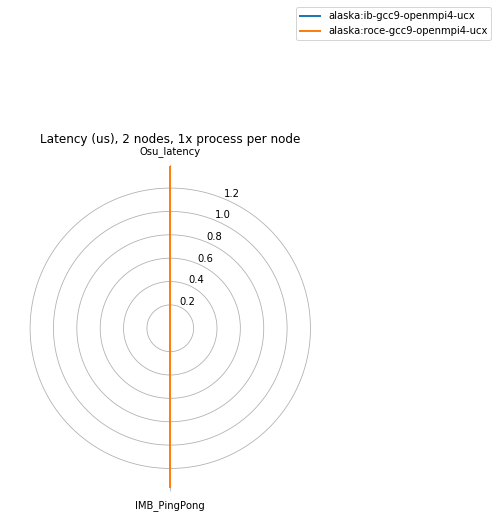

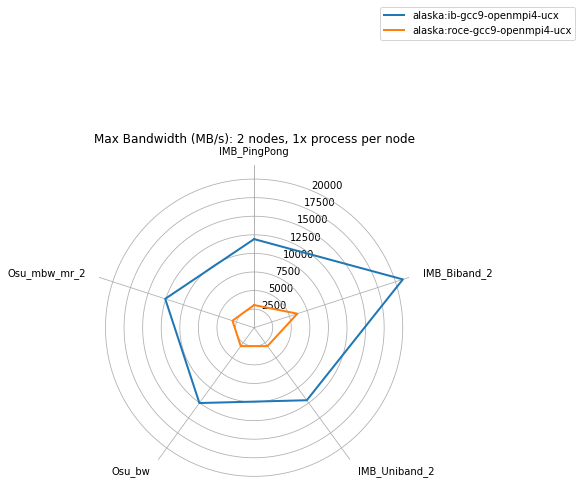

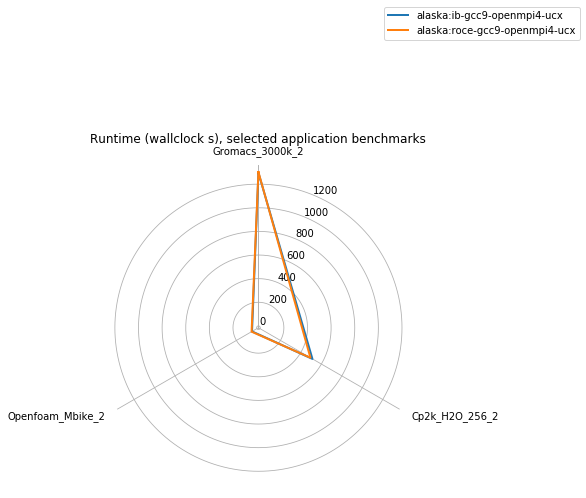

In [25]:
# Plot max bandwidth (for all 2-process tests):

# define systems of interest:
sys = ['alaska:ib-gcc9-openmpi4-ucx', 'alaska:roce-gcc9-openmpi4-ucx']

plot_cfgs = [
              
    
    { # latency from 
        'tests': ('Osu_latency', 'IMB_PingPong'),
        'perf_var': 'min_latency',
        'title': 'Latency (us), 2 nodes, 1x process per node',
    },

    { # bandwidth from synthetic tests with 2x processes:
        'tests': ('IMB_PingPong', 'IMB_Biband_2', 'IMB_Uniband_2', 'Osu_bw', 'Osu_mbw_mr_2'),
        'perf_var': 'max_bandwidth', 
        'title': 'Max Bandwidth (MB/s): 2 nodes, 1x process per node'
    },
    
    { # TODO: these need changing to 16 versions probably??
        'tests': ('Gromacs_3000k_2', 'Cp2k_H2O_256_2', 'Openfoam_Mbike_2'),
        'perf_var':'runtime_real',
        'title': 'Runtime (wallclock s), selected application benchmarks',
    },
]


for plot_cfg in plot_cfgs:
    
    # load perflogs:
    alldf = []
    for test in plot_cfg['tests']:
        df = modules.utils.tabulate_last_perf(test, 'testname', plot_cfg['perf_var'], '../perflogs') # index var doesn't really matter here
        if df is None:
            print('no data for %s - skipping' % test)
            continue
        alldf.append(df.transpose())
    
    # concatenate tests together by case - missing tests get filled with NaN:
    results = pd.concat(alldf, axis=1, sort=False)

    # filter to only those systems of interest:
    results = results.loc[sys]
    rp = RadarPlot(results)
    rp.ax.set_title(plot_cfg['title'])



    